## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wfdb
import pywt
from scipy import signal, integrate
from scipy.optimize import curve_fit

%matplotlib inline
plt.style.use("seaborn-paper")

## Pre-processing

In [2]:
def clean(lead_x):
    wvlt = 'db6'

    # max useful decomposition level
    max_level = pywt.dwt_max_level(data_len=len(lead_x), filter_len=pywt.Wavelet(wvlt).dec_len)

    coeffs = pywt.wavedec(lead_x, wvlt, level=max_level)

    coeffs[0] = np.zeros(len(coeffs[0]))  # remove lowest frequency band
    
    # inverse DWT (multilevel reconstruction)
    idwt = pywt.waverec(coeffs, wvlt)
    
    return idwt

## Record Selection

In [3]:
PATH = "ptbxl/"  # https://physionet.org/content/ptb-xl/1.0.1/
fs = 500.0  # sampling frequency (Hz)
lead = 10

records = pd.read_csv(PATH + "ptbxl_database.csv", index_col="ecg_id", dtype={
    'patient_id': np.int32,
})

In [4]:
lead_keys = [ 'I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6' ]

ld = dict(zip(
    lead_keys,
    range(len(lead_keys))
))

In [5]:
test = clean(wfdb.rdrecord(PATH + records.iloc[100]["filename_hr"]).p_signal[:, ld["II"]])

## Feature Extraction

In [6]:
degree_poly = 5  # degree polynomial

def get_j_points(lead, s_points):
    j_points = []
    
    for point in range(len(s_points) - 1):
        approx_range = int((s_points[point + 1] - s_points[point]) / 4)
        
        x_vals = np.array(range(1, approx_range))
        
        regress_func = np.poly1d(np.polyfit(x_vals, [ test[s_points[point] + i] for i in x_vals ], degree_poly))
        
        j_point = signal.find_peaks(-np.gradient(regress_func(x_vals)))[0][0]
        j_points.append(s_points[point] + j_point)
        
    return j_points

In [7]:
def get_s_points(lead, r_peaks):
    s_points = []

    for i in r_peaks:
        s_points.append(
            i + np.argmin(lead[i:i+50])
        )
        
    return s_points

def get_q_points(lead, r_peaks):
    q_points = []

    for i in r_peaks:
        q_points.append(
            i - np.argmin(np.flip(lead[i-50:i]))
        )
        
    return q_points

In [8]:
r_peaks, _ = signal.find_peaks(test, height=((max(test) - min(test)) / 2))
s_points = get_s_points(test, r_peaks)
q_points = get_q_points(test, r_peaks)
j_points = get_j_points(test, s_points)

Text(0, 0.5, 'Amplitude (mV)')

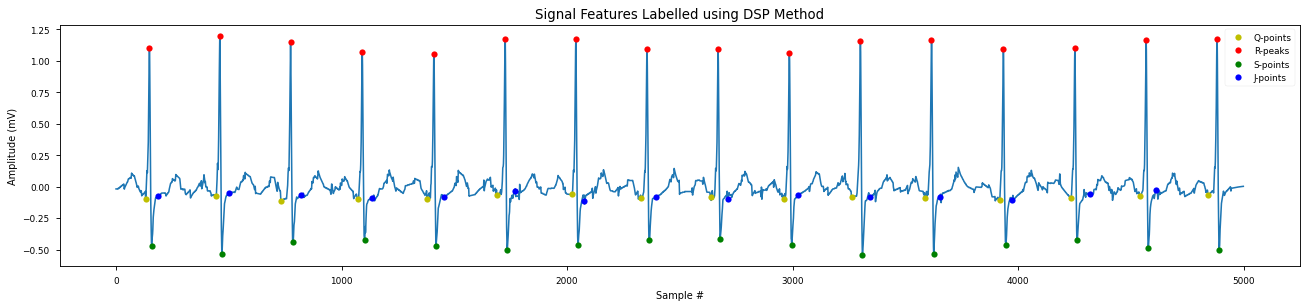

In [9]:
plt.figure(figsize=(20, 4), dpi=80)

plt.plot(test)
plt.plot(q_points, test[q_points], 'yo', label="Q-points")
plt.plot(r_peaks, test[r_peaks], 'ro', label="R-peaks")
plt.plot(s_points, test[s_points], 'go', label="S-points")
plt.plot(j_points, test[j_points], 'bo', label="J-points")

plt.legend(loc="upper right")
plt.title("Signal Features Labelled using DSP Method", fontsize='large')
plt.xlabel('Sample #')
plt.ylabel('Amplitude (mV)')